In [1]:
import numpy as np 
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
def sigmoid(array: np.ndarray) -> np.ndarray:
    sign = np.sign(array)
    exp = np.exp(-sign * array)

    num = np.where(sign < 0, exp, 1)
    den = 1 + exp

    return num / den

In [3]:
iris = datasets.load_iris()
samples = iris.data[:, :2]  # we only take the first two features.
gt_classes = iris.target

In [4]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

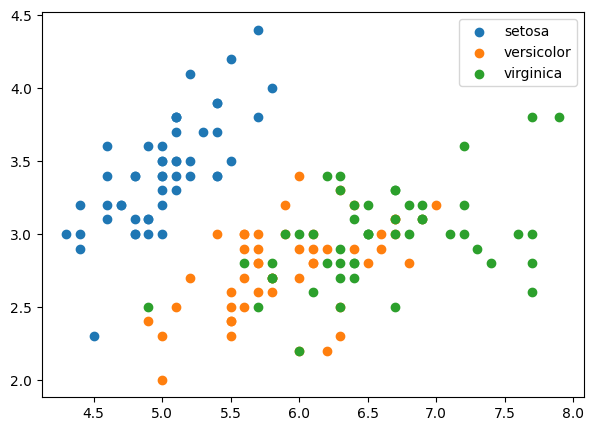

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for label in np.unique(gt_classes):
    ax.scatter(
        samples[gt_classes==label, 0], 
        samples[gt_classes==label, 1], 
        label=iris.target_names[label]
    )
ax.legend()

### Maximum Likelihood

In [6]:
nsamples = samples.shape[0]
X = np.concat([samples.T, np.ones((1, nsamples))], axis=0)
W = gt_classes.copy() == 0
W = W.astype(int)
one_minus_W = 1 - W
XXT = np.einsum("ij, kj -> ikj", X, X)

In [7]:
def objective(phi: np.ndarray) -> np.ndarray:
    phi_X = np.dot(phi, X)

    sign = np.sign(phi_X)
    exp = np.exp(-sign * phi_X)
    log1pexp = np.log1p(exp)

    obj = one_minus_W * phi_X
    obj += np.where(sign >= 0, log1pexp, log1pexp - phi_X)

    return np.sum(obj) / nsamples

def objective_prime(phi: np.ndarray) -> np.ndarray:
    sig_minus_W = sigmoid(np.dot(phi, X)) - W
    return np.einsum("j, ij -> i", sig_minus_W, X) / nsamples

def objective_second(phi: np.ndarray) -> np.ndarray:
    sig_phi_X = sigmoid(np.dot(phi, X))
    return np.einsum("k, ijk -> ij", sig_phi_X * (1 - sig_phi_X), XXT) / nsamples

In [8]:
opt_results = minimize(
    fun=objective,
    x0=np.full((X.shape[0],), 0),
    method="Newton-CG",
    jac=objective_prime,
    hess=objective_second,
    options={"maxiter": 100},
)
print(opt_results)

phi_opt = opt_results.x

 message: Warning: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 8.036351017696017e-05
       x: [-4.690e+01  4.182e+01  1.200e+02]
     nit: 100
     jac: [-2.187e-06 -2.888e-06 -3.506e-06]
    nfev: 105
    njev: 105
    nhev: 100


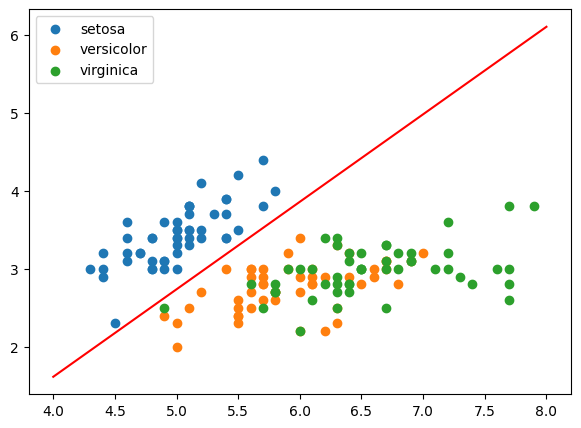

In [9]:
xrange = np.array([4, 8])
y_lim = - (phi_opt[0] * xrange + phi_opt[2]) / phi_opt[1]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for label in np.unique(gt_classes):
    ax.scatter(
        samples[gt_classes==label, 0], 
        samples[gt_classes==label, 1], 
        label=iris.target_names[label]
    )
ax.plot(xrange, y_lim, "r")
ax.legend()

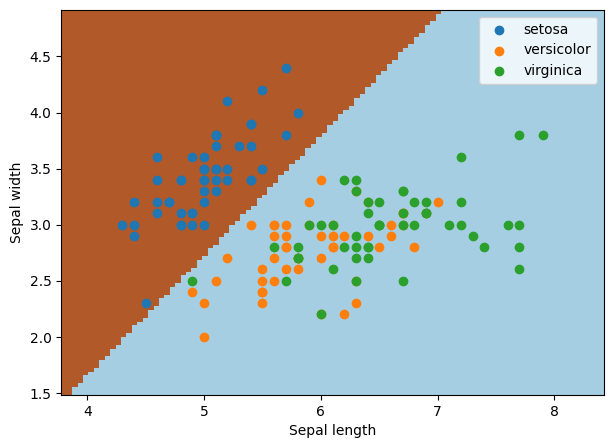

In [10]:
logreg = LogisticRegression(solver="newton-cg")
logreg.fit(samples, W)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
DecisionBoundaryDisplay.from_estimator(
    logreg,
    X[:-1, :].T,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    xlabel="Sepal length",
    ylabel="Sepal width",
    eps=0.5,
)

for label in np.unique(gt_classes):
    ax.scatter(
        samples[gt_classes==label, 0], 
        samples[gt_classes==label, 1], 
        label=iris.target_names[label]
    )
ax.legend()